<a href="https://colab.research.google.com/github/loga115/synthetix/blob/main/Detectron2_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Dependencies

!pip install kaggle
!pip install opencv-python



# Install detectron2 + Setup the dataset
> Add blockquote



In [7]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.


In [9]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121


AttributeError: module 'detectron2' has no attribute '__version__'

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

Checking with a random image

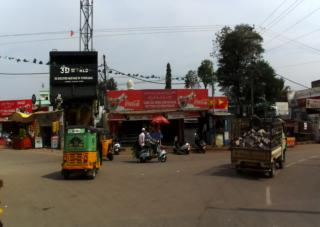

In [11]:
im = cv2.imread("./image3.jpg")
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [12]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[04/17 06:00:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:01, 120MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 7,  0,  0,  7, 25,  0], device='cuda:0')
Boxes(tensor([[230.5958, 116.0602, 287.0353, 177.7458],
        [147.4297, 122.6636, 164.1844, 157.6350],
        [137.5449, 128.0231, 150.1445, 158.8510],
        [ 60.7942, 127.0353, 100.5013, 179.8348],
        [149.7232, 114.2860, 170.2528, 125.7630],
        [138.5310, 127.8490, 146.2373, 150.5367]], device='cuda:0'))


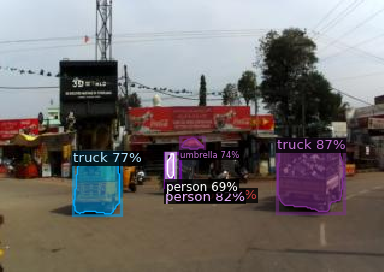

In [14]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# @title Add Dataset
Manually import your kaggle.json file in before running!

In [ ]:
# @title Add Dataset
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d darsh22blc1378/synthetix-programming-dataset
!unzip /content/synthetix-programming-dataset.zip -d dashcams

#@title New Title


In [2]:
import os
import random
import cv2
import numpy as np
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

# Define mask colors
mask_colors = {
    (128, 64, 128): 0,    # road
    (244, 35, 232): 1,    # sidewalk
    (70, 70, 70): 2,      # building
    (102, 102, 156): 3,  # wall
    (190, 153, 153): 4,  # fence
    (153, 153, 153): 5,  # pole
    (250, 170, 30): 6,    # traffic light
    (220, 220, 0): 7,     # signboard
    (107, 142, 35): 8,    # vegetation
    (152, 251, 152): 9,   # terrain
    (70, 130, 180): 10,    # sky
    (220, 20, 60): 11,    # person
    (0, 0, 142): 12,      # car
    (0, 0, 70): 13,       # truck
    (0, 60, 100): 14,     # bus
    (0, 0, 0): 15         # unnamed
}

def load_synthetic_dataset(dataset_dir, subset):
    dataset_dicts = []
    images_dir = os.path.join(dataset_dir, "images", subset)
    segments_dir = os.path.join(dataset_dir, "segments", subset)
    labels_path = os.path.join(dataset_dir, "labels.txt")

    # Load label names from labels.txt
    with open(labels_path, "r") as f:
        label_names = [line.strip().split(":")[1].strip() for line in f.readlines()]

    # Create a mapping from label id to label name
    label_id_mapping = {i: label_name for i, label_name in enumerate(label_names)}

    # Load images and segmentations
    for filename in os.listdir(images_dir):
        record = {}
        img_path = os.path.join(images_dir, filename)
        seg_path = os.path.join(segments_dir, filename)

        # Read image
        img = cv2.imread(img_path)
        height, width = img.shape[:2]

        # Read segmentation and convert to mask
        seg_img = cv2.imread(seg_path)
        seg_mask = np.zeros((height, width), dtype=np.uint8)
        for color, label_id in mask_colors.items():
            mask = np.all(seg_img == color, axis=-1)
            seg_mask[mask] = label_id

        # Create annotation
        annotations = [{
            "bbox": [0, 0, width, height],
            "bbox_mode": BoxMode.XYXY_ABS,
            "segmentation": seg_mask,
            "category_id": 0,  # We have only one category
            "category_name": label_id_mapping[label_id]
        }]

        record["file_name"] = img_path
        record["height"] = height
        record["width"] = width
        record["image_id"] = filename.split(".")[0]
        record["annotations"] = annotations

        dataset_dicts.append(record)

    return dataset_dicts

ModuleNotFoundError: No module named 'detectron2.data'

In [10]:
DatasetCatalog.register("synthetix_dataset_train", lambda: load_synthetic_dataset("dashcams", "train"))
DatasetCatalog.register("synthetix_dataset_val", lambda: load_synthetic_dataset("dashcams", "val"))
MetadataCatalog.get("synthetix_dataset_train").set(thing_classes=["object"])
MetadataCatalog.get("synthetix_dataset_val").set(thing_classes=["object"])

namespace(name='synthetix_dataset_val', thing_classes=['object'])

In [ ]:

# Training
cfg = get_cfg()
cfg.merge_from_file("detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("synthetix_dataset_train",)
cfg.DATASETS.TEST = ("synthetix_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # Load pre-trained weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300    # Adjust depending on your dataset
cfg.SOLVER.STEPS = []        # Adjust depending on your dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have only one class

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/17 06:09:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:

# Visualization
# Randomly select an image from validation dataset
dataset_dicts = load_synthetic_dataset("dashcams", "val")
metadata = MetadataCatalog.get("synthetix_dataset_1_val")
random_image_dict = random.choice(dataset_dicts)
random_image = cv2.imread(random_image_dict["file_name"])

# Predict
outputs = trainer.model(random_image)

# Visualize
v = Visualizer(random_image[:, :, ::-1], metadata=metadata, scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()
